In [1]:
% matplotlib nbagg
import numpy as np # import numpy library as np
import matplotlib.pyplot as plt # import pyplot library as plt 
import matplotlib.mlab as mlab # import mlab module to use MATLAB commands with the same names
import matplotlib.animation as animation # import animation modules from matplotlib
from   mpl_toolkits.mplot3d import Axes3D # import Axes3D from mpl_toolkits.mplot3d
from   numpy import newaxis
plt.style.use('ggplot') # use "ggplot" style for graphs

In [2]:
# wrap r around periodic boundaries
def pbc(r, lbox):
    return np.fmod(r + lbox, lbox)

# compute pbc distance r2 - r1
def distance(r1, r2, lbox):
    return r2 - r1 - np.around((r2 - r1)/lbox)*lbox
    
# compute forces given distance r2 and distance vectors rij
def fij(r2, rij):
    return -24*eps*(2*(r2/sig2)**(-6)-(r2/sig2)**(-3))/r2*rij

# compute all forces
def particleforces():
    global F
    F[:,:] = 0.0
    for n in range(nump):
        rij = distance(R[n,:], R, box)        # distance vectors from particle n : R_m - R_n forall m
        r2  = np.linalg.norm(rij, axis=1)**2  # distance values
        nei = (r2 < rc2)                      # neighbor particles
        nei[n] = False                        # ignore self force
        F[n,:] = np.sum(fij(r2[nei, newaxis], rij[nei,:]), axis=0) # total force on particle n

# perform one md step
def mdstep(i):
    global R,V,W,F
    particleforces()
    W = std*np.random.randn(nump, dim)
    V = V*(1 - zeta/m*dt) + (F*dt + W)/m
    R = pbc(R + V*dt, box)
    Rs[i,:,:] = R
    Vs[i,:,:] = V
    Ws[i,:,:] = W    
    time[i] = i*dt
    
# random particle configuration
def initconf():
    global R,V,W,F,Rs,Vs,Ws,time

    time[:] = 0.0
    R[:,:], V[:,:], W[:,:], F[:,:] = 0.0, 0.0, 0.0, 0.0
    Rs[:,:,:], Vs[:,:,:], Ws[:,:,:] = 0.0, 0.0, 0.0

    for n in range(nump): # repeat below from n=0 to nump-1
        nn=0              # set overlap true to perform while loop below for the n-th particle 

        while nn == 0:  # repeat the loop below while overlap is true (nn==0)
            R[n,:]=np.random.rand(dim)*box   # generate a position candidate for n using uniform random number.
            nn = 1                           # initialize overlap as false
            for l in range(n):               # examine overlap generated positions (from l=0 to n-1)
                rij = distance(R[n,:],R[l,:],box) # calculate distance vector rij=R_l-R_n
                r2  = np.linalg.norm(rij)**2      # calculate the squared distance rij**2
                if r2 < (0.8*sig)**2:             # check if the distance is smaller than threshold
                # Yes -> perform below (nn=0) -> repeat while loop, No (nn=1) -> exit while loop
                    nn = 0 # set overlap true 
                    

In [3]:
# update artists (particles, lines, etc)
def artistupdate(i):
    title.set_text(r"t = "+str(time[i])) 
    line.set_data(Rs[:i+1,trace,0],Rs[:i+1,trace,1]) 
    line.set_3d_properties(Rs[:i+1,trace,2]) 
    particles.set_data(R[:,0], R[:,1])  # set the current position of all the particles in 2d (x,y)
    particles.set_3d_properties(R[:,2]) # add z axis to set the particle in 3D
    return title, line, particles

def animate(i):
    global R,V,W,F,Rs,Vs,Ws,time 
    mdstep(i)  
    return artistupdate(i)

In [4]:
dim  = 3    # system dimension (x,y,z)
nump = 80  # number of independent Brownian particles to simulate 
nums = 1024 # number of simulation steps
dt   = 0.01 # set time increment, \Delta t
zeta = 1.0  # set friction constant, \zeta
m    = 1.0  # set particle mass, m
kBT  = 1.0  # set temperatute, k_B T
trace= 0    # id of tracer particle
std  = np.sqrt(2*kBT*zeta*dt) # calculate std for \Delta W via Eq.(F11)

sig = 1.0
eps = 1.0
rc2 = (2.5*sig)**2
sig2= sig**2

box = np.array([10.0, 10.0, 10.0])*sig # set draw area as box^3

np.random.seed(0)           
R = np.zeros([nump,dim]) 
V = np.zeros([nump,dim]) 
W = np.zeros([nump,dim]) 
F = np.zeros([nump,dim]) 
Rs = np.zeros([nums,nump,dim])
Vs = np.zeros([nums,nump,dim])
Ws = np.zeros([nums,nump,dim])
time = np.zeros([nums]) 

<IPython.core.display.Javascript object>


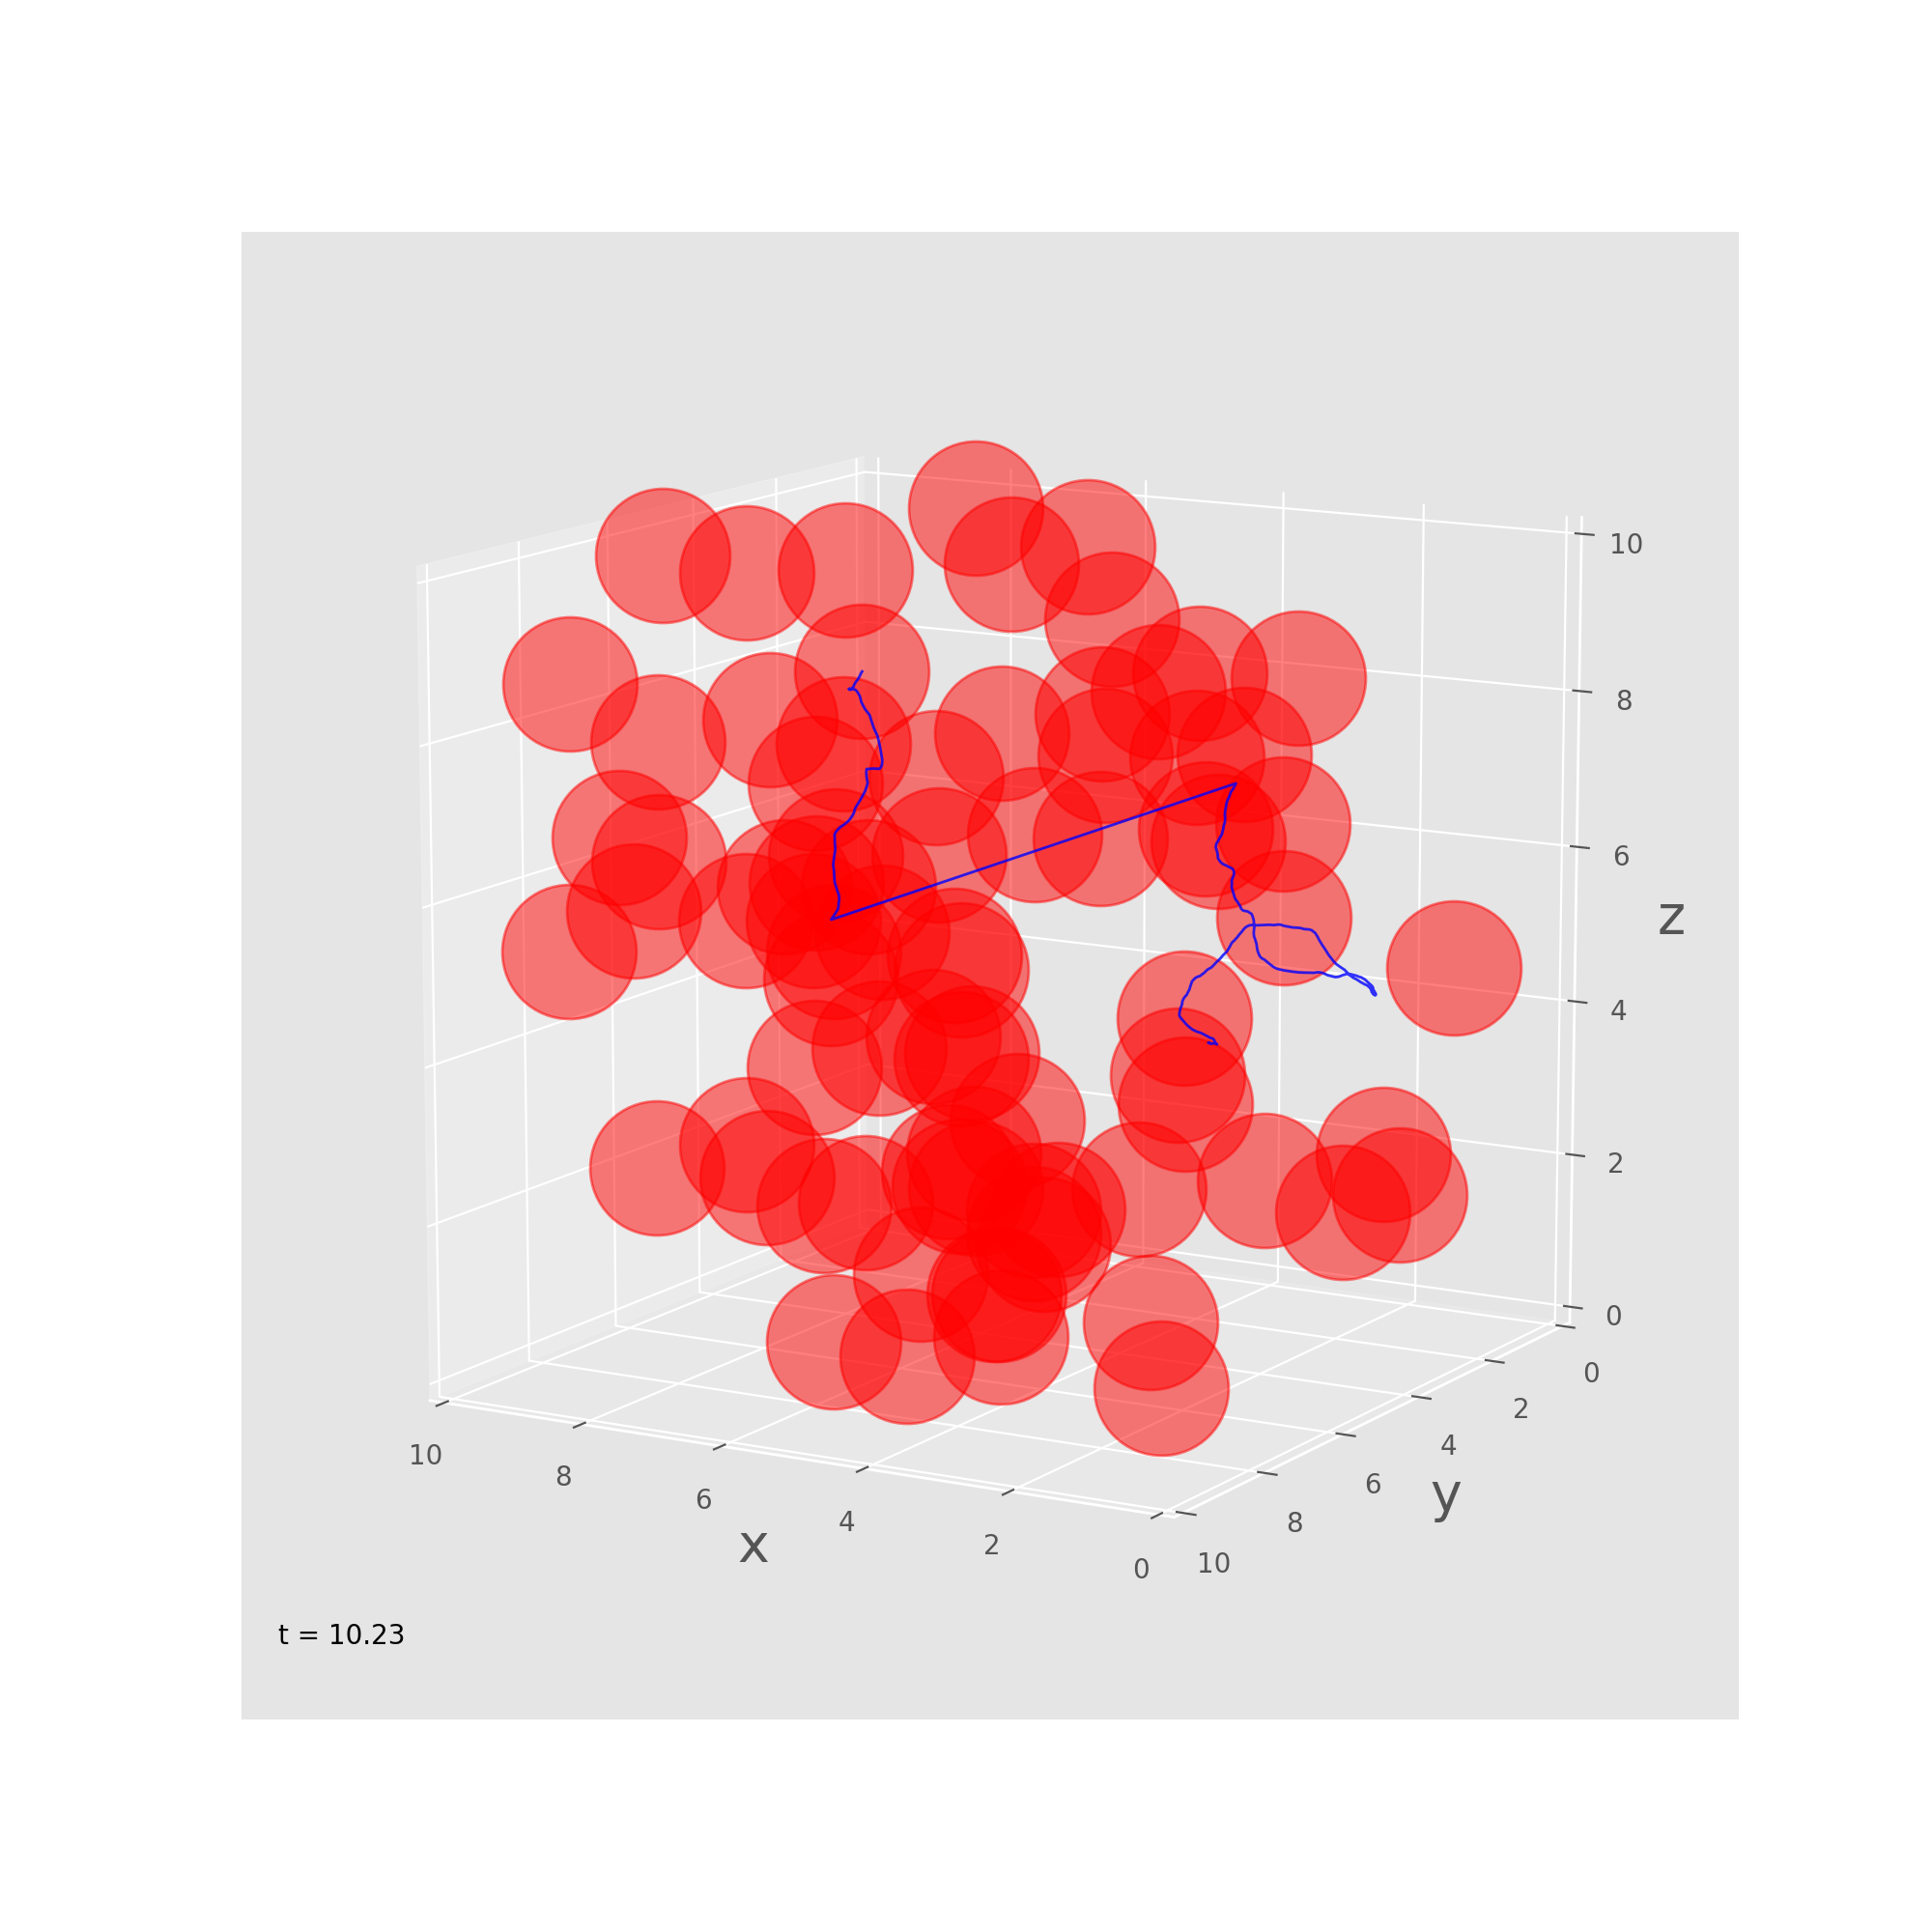

In [7]:
fig = plt.figure(figsize=(10,10)) # set fig with its size 10 x 10 inch
ax = fig.add_subplot(111,projection='3d') # creates an additional axis to the standard 2D axes
ax.set_xlim(0.0,box[0]) # set x-range
ax.set_ylim(0.0,box[1]) # set y-range
ax.set_zlim(0.0,box[2]) # set z-range
ax.set_xlabel(r"x",fontsize=20) # set x-lavel
ax.set_ylabel(r"y",fontsize=20) # set y-lavel
ax.set_zlabel(r"z",fontsize=20) # set z-lavel
ax.view_init(elev=12,azim=120)  # set view point

alpha = np.ones(nump)*0.5
particles, = ax.plot([],[],[],'ro',ms=50,alpha=0.5)                        # define object particles
title = ax.text(box[0]/2.0,0.,box[2],r'',transform=ax.transAxes,va='center') # define object title
line, = ax.plot([],[],[],'b',lw=1,alpha=0.8)                          # define object line

initconf()
anim = animation.FuncAnimation(fig,func=animate,frames=nums,interval=5,blit=True,repeat=False)